<a href="https://colab.research.google.com/github/SUPT-Pashe10019/SUPT-Wolfram-Integration/blob/main/AeroFlux_v0_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyvista scipy matplotlib numpy
!pip install vtk


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 7.7 MB/s eta 0:00:00


In [2]:
from google.colab import files

uploaded = files.upload()


Saving PERRINN_F1_CFD_Scaled_FullCar.zip to PERRINN_F1_CFD_Scaled_FullCar.zip


In [5]:
import os

# Rename for easier handling
os.rename("perrinn_car/PERRINN_F1_CFD_Scaled_FullCar - Part 1.stl",
          "perrinn_car/perrinn_f1.stl")

# Now load it
mesh = pv.read("perrinn_car/perrinn_f1.stl")
print(mesh)

# Static plot
plotter = pv.Plotter(notebook=False)
plotter.add_mesh(mesh, color='lightblue')
plotter.show(screenshot='perrinn_static_view.png')


PolyData (0x7c60efae10c0)
  N Cells:    1523574
  N Points:   761673
  N Strips:   0
  X Bounds:   -5.555e+01, 1.935e+02
  Y Bounds:   -4.598e+01, 4.598e+01
  Z Bounds:   -2.346e+00, 4.814e+01
  N Arrays:   0


In [15]:
import numpy as np
import pyvista as pv

# Load STL mesh
mesh = pv.read("perrinn_car/perrinn_f1.stl")

# Define grid size
nx, ny, nz = 100, 100, 100
x = np.linspace(mesh.bounds[0], mesh.bounds[1], nx)
y = np.linspace(mesh.bounds[2], mesh.bounds[3], ny)
z = np.linspace(mesh.bounds[4], mesh.bounds[5], nz)

# Create structured grid from meshgrid
xv, yv, zv = np.meshgrid(x, y, z, indexing='ij')
grid = pv.StructuredGrid(xv, yv, zv)

# Mark which grid points are inside the car surface
enclosed = grid.select_enclosed_points(mesh, tolerance=0.0, check_surface=False)
inside_grid = enclosed.point_data['SelectedPoints'].reshape((nx, ny, nz)) == 1



In [16]:
# Initialize wavefield (velocity potential or resonance energy)
phi = np.zeros((nx, ny, nz))
wave_memory = np.zeros_like(phi)



In [17]:
def update_harmonic_field(phi, inside_grid, t, freq=2.5, amp=0.3, decay=0.01):
    global wave_memory

    # Time-phase evolution
    time_phase = np.sin(2 * np.pi * freq * t / 100)

    # Create 3D envelope (use xv, yv, zv for full lattice)
    envelope = amp * np.cos(2 * np.pi * (xv + yv + zv) * 0.01 - time_phase)

    # No flow inside the car
    envelope[inside_grid] = 0

    # Dissipative memory accumulation (mimics coherence locking)
    wave_memory[:] = (1 - decay) * wave_memory + envelope
    phi[:] = wave_memory
    return phi


In [18]:
# Simulate 100 timesteps
for t in range(100):
    phi = update_harmonic_field(phi, inside_grid, t)


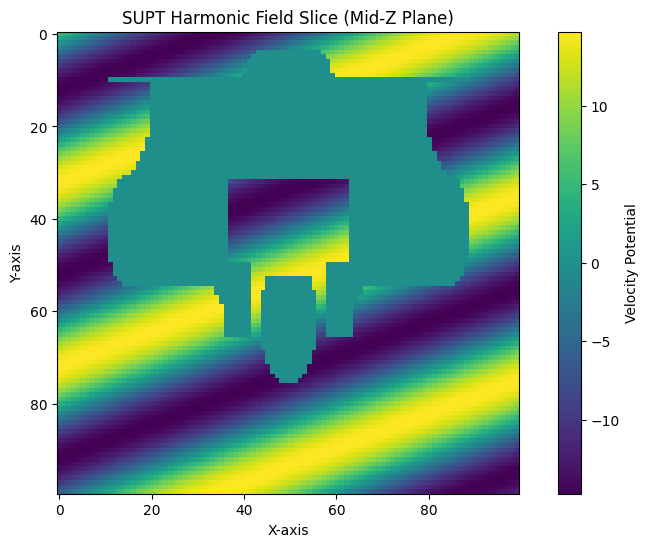

In [19]:
import matplotlib.pyplot as plt

# Show a slice of the wavefield at mid-z
plt.figure(figsize=(10, 6))
plt.imshow(phi[:, :, phi.shape[2] // 2], cmap='viridis')
plt.title("SUPT Harmonic Field Slice (Mid-Z Plane)")
plt.colorbar(label="Velocity Potential")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()


In [20]:
# Compute grid spacing
dx = (x[-1] - x[0]) / (len(x) - 1)
dy = (y[-1] - y[0]) / (len(y) - 1)
dz = (z[-1] - z[0]) / (len(z) - 1)

# Compute gradient: u = ∇φ
u_x, u_y, u_z = np.gradient(phi, dx, dy, dz)


In [21]:
# Select mid-plane
mid_z = phi.shape[2] // 2
U = u_x[:, :, mid_z]
V = u_y[:, :, mid_z]

# Compute vorticity ω_z = ∂V/∂x - ∂U/∂y
omega_z = np.gradient(V, dx, axis=0) - np.gradient(U, dy, axis=1)


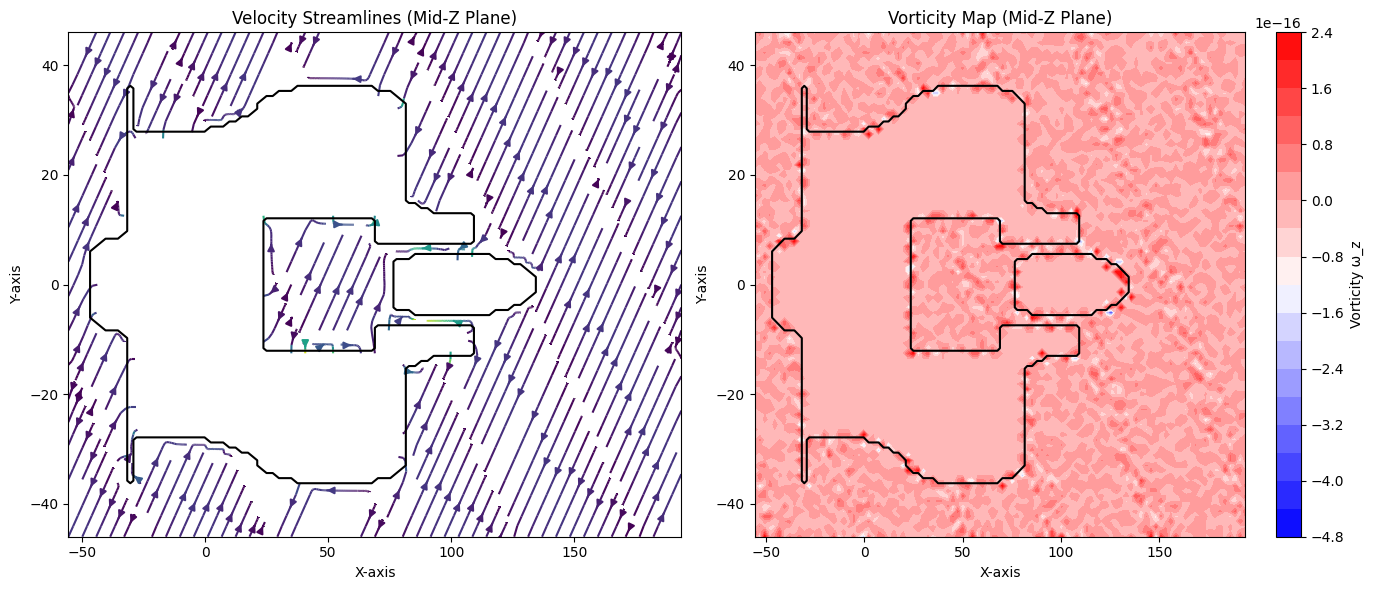

In [22]:
import matplotlib.pyplot as plt

# Plot velocity streamlines and vorticity
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# 1. Streamlines
ax[0].streamplot(x, y, U.T, V.T, color=np.sqrt(U.T**2 + V.T**2), cmap='viridis', density=1.5)
ax[0].contour(x, y, inside_grid[:, :, mid_z].T, levels=[0.5], colors='black')
ax[0].set_title("Velocity Streamlines (Mid-Z Plane)")
ax[0].set_xlabel("X-axis")
ax[0].set_ylabel("Y-axis")

# 2. Vorticity field
c = ax[1].contourf(x, y, omega_z.T, levels=20, cmap='bwr')
fig.colorbar(c, ax=ax[1], label="Vorticity ω_z")
ax[1].contour(x, y, inside_grid[:, :, mid_z].T, levels=[0.5], colors='black')
ax[1].set_title("Vorticity Map (Mid-Z Plane)")
ax[1].set_xlabel("X-axis")
ax[1].set_ylabel("Y-axis")

plt.tight_layout()
plt.show()


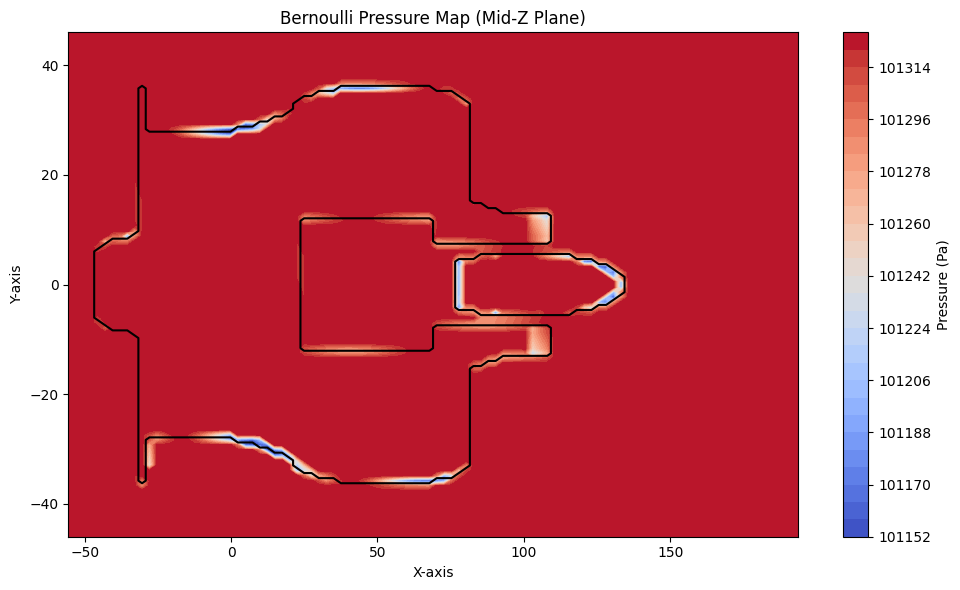

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# --- Assumes you have these already loaded ---
# phi: the harmonic field [shape: (nx, ny, nz)]
# x, y, z: 1D grid vectors (each length nx, ny, nz)
# inside_grid: 3D car mask (1 = inside car, 0 = flow domain)

# Step 1: Compute velocity field (gradient of velocity potential)
u_x, u_y, u_z = np.gradient(phi, x, y, z)

# Step 2: Compute velocity magnitude
velocity_magnitude = np.sqrt(u_x**2 + u_y**2 + u_z**2)

# Step 3: Bernoulli pressure (inviscid, incompressible)
P0 = 101325  # Reference pressure (Pa)
rho = 1.225  # Air density (kg/m³)
pressure = P0 - 0.5 * rho * velocity_magnitude**2

# Step 4: Extract and visualize mid-Z slice
mid_z = phi.shape[2] // 2
pressure_slice = pressure[:, :, mid_z]

plt.figure(figsize=(10, 6))
contour = plt.contourf(x, y, pressure_slice.T, cmap='coolwarm', levels=30)
plt.colorbar(contour, label='Pressure (Pa)')
plt.contour(x, y, inside_grid[:, :, mid_z].T, levels=[0.5], colors='black')

plt.title("Bernoulli Pressure Map (Mid-Z Plane)")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.tight_layout()
plt.show()


In [34]:
# 1. Compute normals and cell sizes on a *copied* mesh (to preserve data)
mesh = mesh.compute_normals(cell_normals=True, point_normals=False, inplace=False)
mesh = mesh.compute_cell_sizes(length=False, area=True, volume=False)

# 2. Extract geometry properties
normals = mesh.cell_data['Normals']     # (N_faces, 3)
areas   = mesh.cell_data['Area']        # (N_faces,) ✅ lowercase! Corrected key
centroids = mesh.cell_centers().points  # (N_faces, 3)



In [35]:
from scipy.interpolate import interpn

pressure_at_centroids = interpn(
    points=(x, y, z),
    values=pressure,
    xi=centroids,
    method='linear',
    bounds_error=False,
    fill_value=np.mean(pressure)
)

force_vectors = -pressure_at_centroids[:, None] * areas[:, None] * normals
total_force = force_vectors.sum(axis=0)


In [36]:
# Each face contributes: -P * Area * Normal
force_vectors = -pressure_at_centroids[:, None] * areas[:, None] * normals


In [37]:
total_force = force_vectors.sum(axis=0)
drag_force = total_force[0]   # Assuming flow is in +X
lift_force = total_force[2]   # Z = vertical (positive = upward)


In [38]:
rho = 1.225      # Air density (kg/m³)
V = 50           # Flow speed (m/s)
A_ref = 1.5      # Reference area (m²), adjust if needed

q = 0.5 * rho * V**2  # Dynamic pressure
Cd = drag_force / (q * A_ref)
Cl = lift_force / (q * A_ref)


In [39]:
print(f"Total Drag Force: {drag_force:.2f} N")
print(f"Total Lift Force: {lift_force:.2f} N")
print(f"Drag Coefficient Cd: {Cd:.3f}")
print(f"Lift Coefficient Cl: {Cl:.3f}")


Total Drag Force: -12810.93 N
Total Lift Force: 31016.38 N
Drag Coefficient Cd: -5.578
Lift Coefficient Cl: 13.504


In [45]:
import pyvista as pv

# Create a PolyData object for the centroids
centroid_cloud = pv.PolyData(centroids)

# Attach the force vectors (scaled for visibility)
centroid_cloud['force'] = force_vectors * 0.01  # Adjust scale as needed

# Glyph the vectors into arrows
glyphs = centroid_cloud.glyph(orient='force', scale=False, factor=1.0)

# Plot the mesh and arrows
plotter = pv.Plotter()
plotter.add_mesh(mesh, color='lightgray', opacity=0.5)
plotter.add_mesh(glyphs, color='red')
plotter.add_title("Surface Force Vectors on PERRINN F1")
plotter.show()



In [47]:
print("Centroids shape:", centroids.shape)
print("Force vectors shape:", force_vectors.shape)
print("Sample centroid:", centroids[0])
print("Sample force vector:", force_vectors[0])
print("Force vector norm (magnitude):", np.linalg.norm(force_vectors[0]))


Centroids shape: (1523574, 3)
Force vectors shape: (1523574, 3)
Sample centroid: [91.28649139  1.15441918 43.92921066]
Sample force vector: [   -0.            -0.         -3664.52408346]
Force vector norm (magnitude): 3664.524083460268


In [49]:
# Downsample glyphs to avoid overloading renderer
subset = np.random.choice(len(centroids), size=2000, replace=False)
subset_centroids = centroids[subset]
subset_forces = force_vectors[subset]

arrow_cloud = pv.PolyData(subset_centroids)
arrow_cloud['force'] = subset_forces

glyphs = arrow_cloud.glyph(orient='force', scale=False, factor=0.001)

# Show in lightweight viewer
plotter = pv.Plotter()
plotter.add_mesh(mesh, color='lightgrey', opacity=0.3)
plotter.add_mesh(glyphs, color='crimson')
plotter.add_title("Sampled Surface Force Vectors (PERRINN F1)")
plotter.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [50]:
glyphs = arrow_cloud.glyph(orient='force', scale=False, factor=1.0)
print("Glyphs generated:", glyphs.n_points)


Glyphs generated: 62000


In [51]:
mesh.cell_data['force'] = force_vectors
mesh.cell_data['pressure'] = pressure_at_centroids
mesh.save("PERRINN_F1_SUPT_ForceField.vtk")
